# Прогнозирование оттока клиентов «Ниединогоразрыва.ком»

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

***Описание данных***

**Признаки**:

- BeginDate – дата начала пользования услугами 
- Type – тип оплаты: ежемесячный, годовой и тд 
- PaperlessBilling – безналичный расчет
- PaymentMethod – способ оплаты 
- MonthlyCharges – ежемесячные траты на услуги 
- TotalCharges – всего потрачено денег на услуги 
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

**Целевой признак**:
- EndDate – дата окончания пользования услугами (где 0 - действующие клиенты, 1 - ушедшие клиенты)

**Используемая метрика:** AUC-ROC

**Дополнительная метрика:** accuracy — доля правильных ответов

**Цель проекта:** построить модель со значением AUC-ROC >= 0.85



<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Информация-о-договоре" data-toc-modified-id="Информация-о-договоре-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Информация о договоре</a></span></li><li><span><a href="#Персональные-данные-клиента" data-toc-modified-id="Персональные-данные-клиента-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Персональные данные клиента</a></span></li><li><span><a href="#Информация-об-интернет-услугах" data-toc-modified-id="Информация-об-интернет-услугах-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Информация об интернет-услугах</a></span></li><li><span><a href="#Информация-об-услугах-телефонии" data-toc-modified-id="Информация-об-услугах-телефонии-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Информация об услугах телефонии</a></span></li><li><span><a href="#Объединение-таблиц-и-вывод" data-toc-modified-id="Объединение-таблиц-и-вывод-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Объединение таблиц и вывод</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Кодирование-признаков" data-toc-modified-id="Кодирование-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Кодирование признаков</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Загрузка и предобработка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn import metrics
from phik import resources, report
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix, make_scorer, roc_curve, roc_auc_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix

In [3]:
#загружаем датафреймы
try:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')
    
except:
    
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
    

### Информация о договоре

In [4]:
#выведем первые 5 строк
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
#общая информация о датасете
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Мы видим, что пропусков в данных нет.

Столбцы BeginDate и EndDate нам необходимо привести к формату datetime и сгенерировать новый признак сколько дней человек является клиентом банка.

Столбец TotalCharges привести к вещественному типу.

Название столбцов сделать в стиле snake_case.

In [6]:
#приводим столбцы к змеиному регистру
contract = \
contract.rename\
(columns={'customerID':'customer_id','BeginDate':'begin_date', 'EndDate': 'end_date',\
          'Type': 'type',\
         'PaperlessBilling': 'paperless_billing', 'PaymentMethod':'payment_method',\
          'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges'})

In [7]:
#приводим столбец к формату даты
contract['begin_date'] = pd.to_datetime(contract['begin_date'],  format='%Y-%m-%d')

В столбце end_date заменим значение 'No' на актуальную дату, чтобы мы его смогли привезти к формату datetime:

In [8]:
contract.loc[contract['end_date']== 'No', 'end_date'] = '2020-02-01'

In [9]:
contract.loc[contract['end_date']== '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.8


In [10]:
#приводем столбец к формату даты
contract['end_date'] = pd.to_datetime(contract['end_date'],  format='%Y-%m-%d')

In [12]:
#cоздадим новый признак, сколько дней клиент пользуется услугами компании
contract['tenure'] = (contract['end_date'] - contract['begin_date'])/np.timedelta64(1, 'D')
contract['tenure'] = contract['tenure'].astype('int64')

При попытке поменять тип столбца total_charges было выявлено наличие пробелов. Сделаем срез по ним:

In [15]:
contract.loc[contract['total_charges']== ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0


Мы видим, что это новые клиенты только заключившие договор. Поменяем пустые значения total_charges(всего потрачено денег) на ежемесячные траты:

In [16]:
contract.loc[contract['total_charges']== ' ', 'total_charges'] = contract['monthly_charges']

In [17]:
#проверим изменения
contract.loc[contract['begin_date']== '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,19.85,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,20.0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,19.7,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,73.35,0


In [18]:
#приведем значение столбца к вещественному числу
contract['total_charges'] = contract['total_charges'].astype(float)

Создадим новый столбец exit (целевой признак) на основе значений в столбце end_date (дата окончания пользования услугами ). Дату '2020-02-01' меняем на 0 - это лояльные (действующие клиенты), остальные даты на 1 - ушедшие клиенты:

In [19]:
contract['exit'] = np.where(contract['end_date']== '2020-02-01', 0, 1)

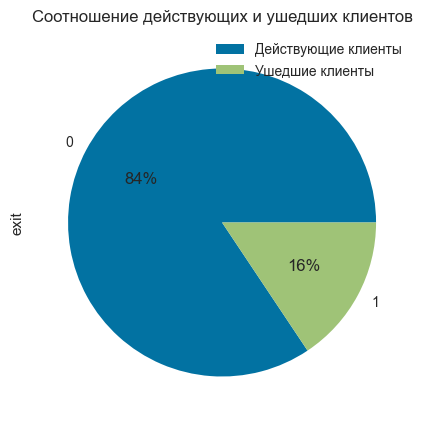

In [20]:
#посмотрим на соотношение действующих и ушедших клиентов
contract['exit'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%.0f%%')

plt.title('Соотношение действующих и ушедших клиентов')
plt.legend(['Действующие клиенты', 'Ушедшие клиенты'], loc='upper right'); 

Мы видим дисбаланс классов.

In [21]:
#проверяем изменения
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   tenure             7043 non-null   int64         
 9   exit               7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


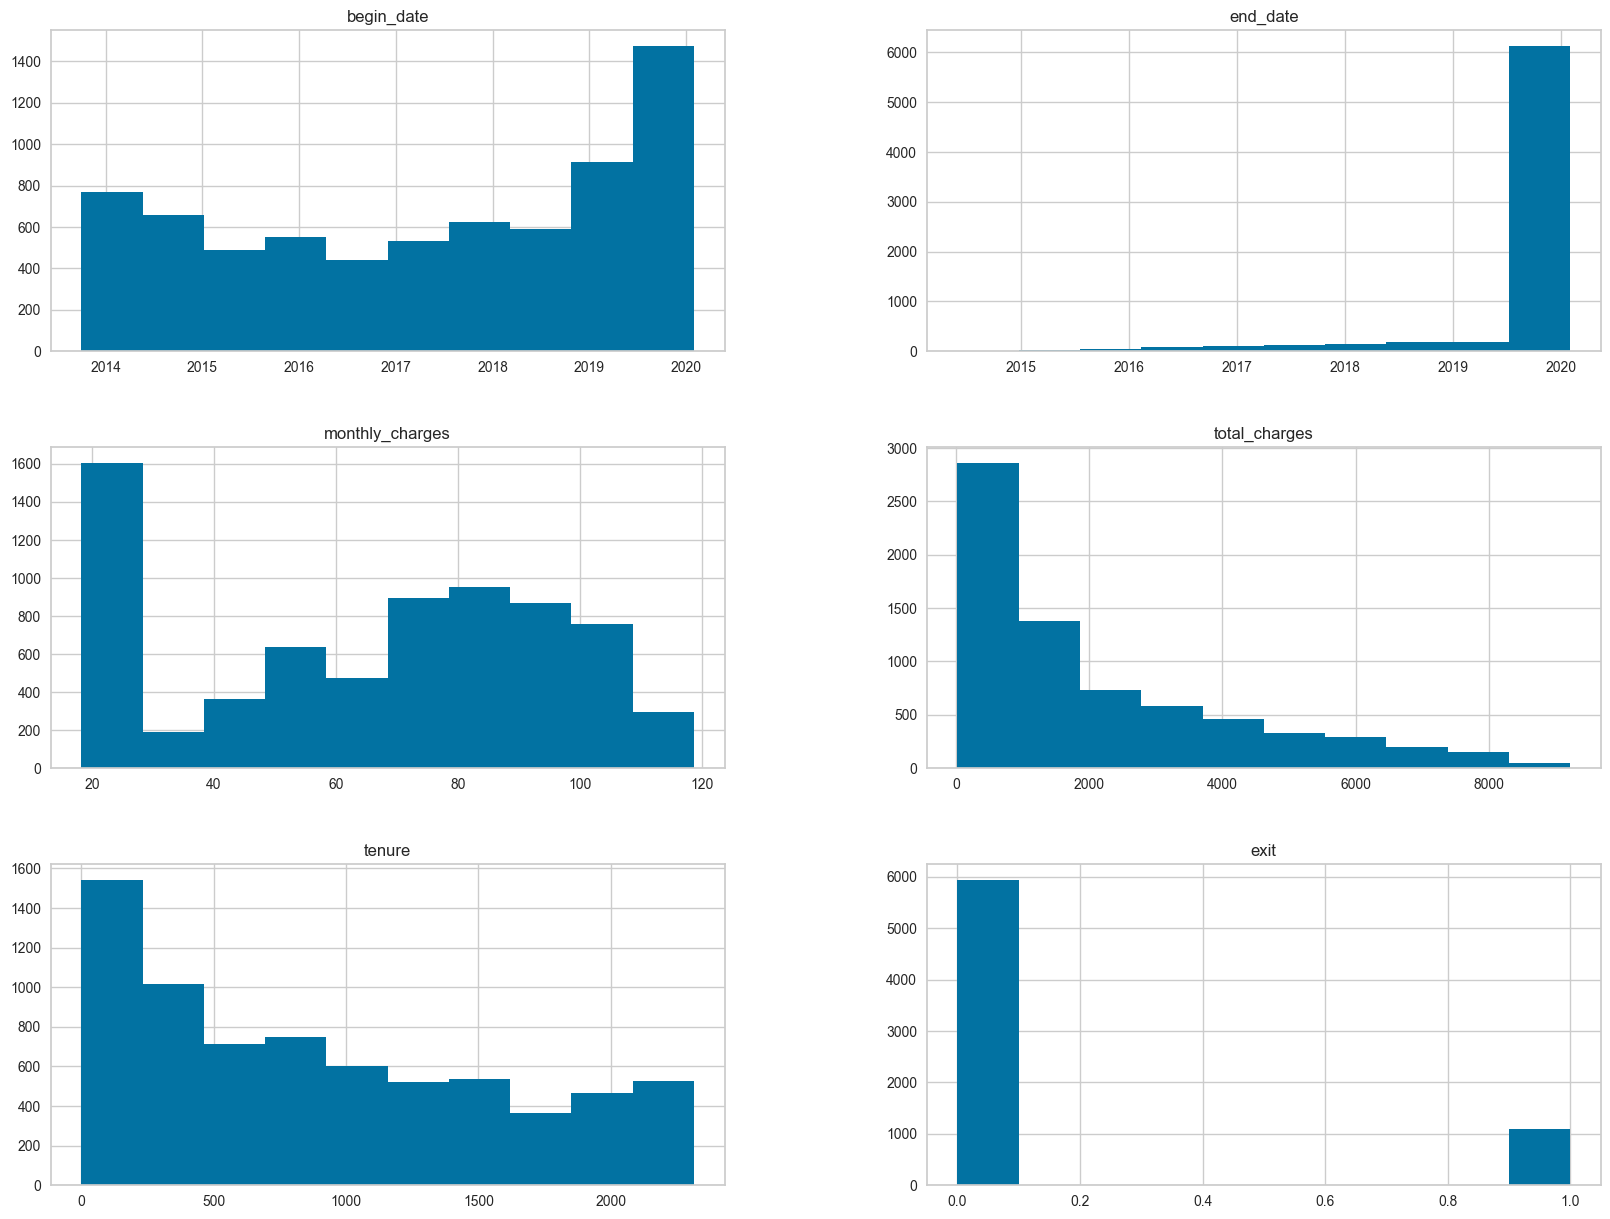

In [22]:
#построим гистограммы
contract.hist(figsize=(20,15));

Мы видим, что больше всего клиентов появилось в 2020 году.
Чаще всего ежемесячные траты составляют около от 17 до 30, а общие до 1000.
Больше всего на данный момент клиентов, которые обсуживаются у оператора меньше года, но и постоянных клиентов тоже немало. 

### Персональные данные клиента

In [23]:
#выведем первые 5 строк
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [24]:
#посмотрим общую информацию о данных
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет. 
Все признаки категориальные, приведем название столбцов к змеиному регистру.

In [25]:
#приводим столбцы к змеиному регистру
personal = \
personal.rename\
(columns={'customerID':'customer_id','SeniorCitizen':'senior_citizen', 'Partner': 'partner',\
          'Dependents': 'dependents'})

### Информация об интернет-услугах

In [26]:
#выведем первые 5 строк
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [27]:
#посмотрим общую информацию о данных
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет. 
Все признаки категориальные, приведем название столбцов к змеиному регистру.
Также мы видим, что количество строк в данном датафрейме, меньше чем в прошлых, соостветственно, 1526 клиентов не пользуетcя интернет-услугами нашего оператора.

In [29]:
#приводим столбцы к змеиному регистру
internet = \
internet.rename\
(columns={'customerID':'customer_id','InternetService':'internet_service', 'OnlineSecurity': 'online_security',\
          'OnlineBackup': 'online_backup',\
         'DeviceProtection': 'device_protection', 'TechSupport':'tech_support',\
          'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies'})

### Информация об услугах телефонии

In [30]:
#выведем первые 5 строк
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [31]:
#посмотрим общую информацию о данных
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [32]:
phone = \
phone.rename\
(columns={'customerID':'customer_id','MultipleLines':'multiple_lines'})

Пропусков нет. Признак категориальный. Клиентов, использующих телефонию больше, чем тех, кто пользуется интернет-услугами. 

### Объединение таблиц и вывод

In [33]:
#объединяем таблицы
data = contract.merge(personal, on='customer_id', how='left')\
.merge(internet, on='customer_id', how='left')\
.merge(phone, on='customer_id', how='left')

data.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure,exit,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
4531,4910-AQFFX,2019-02-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),79.35,634.80,242,1,...,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Yes
4266,5445-PZWGX,2014-11-01,2018-05-01,One year,No,Electronic check,102.00,4284.00,1277,1,...,No,No,Fiber optic,Yes,Yes,No,Yes,No,Yes,Yes
5273,7673-BQGKU,2014-05-01,2016-09-01,Two year,No,Bank transfer (automatic),20.15,586.77,854,1,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
556,2654-VBVPB,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),19.90,21.29,31,0,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
493,5756-OZRIO,2015-01-01,2020-02-01,One year,No,Bank transfer (automatic),64.05,4258.68,1857,0,...,Yes,No,DSL,No,Yes,No,No,No,Yes,Yes


In [34]:
#посмотрим на пропуски после слияния
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
tenure                  0
exit                    0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Пропуски значений при объединении таблиц в дополнительных услугах оператора, значит клиент их не использовал, заполним их значением 'No':

In [35]:
data = data.fillna('No')

In [36]:
#проверяем заполение
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   tenure             7043 non-null   int64         
 9   exit               7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

***Вывод:***

На данном этапе мы ознакомились с данными по всем датафреймам и провели предобработку данных:
 - в данных по договору (contact): 
    - привели названия столбцов к змеиному регистру
    - поменяли типы данных в стобцах begin_date, end_date,total_charges
    - заполнили пропуски в столбце total_charges у новых клиентов ежемесячными тратами
    - сгенерировали новый признак tenure (сколько дней клиент пользуется услугами)
    - создали целевой признак exit, где 1 - ушедшие клиенты, а 0 - лояльные клиенты
    - выявили дисбаланс классов
    - на гистограммах увидели, что больше всего клиентов до года, ежемесячные траты чаще всего от 17 до 30, а общие траты чаще всего до 1000
  - в датасетах по персональным данным, интернету и телефонии:
     - привели названия столбцов к змеиному регистру
     - выявили, что все признаки категориальные
     - выяснили, что клиентов, пользующихся услугами телефонии, у нашего оператора больше, чем интернет-услугами
  - объединили таблицу в одну и заполнили возникшие в доп услугах пропуски при объединении значением 'No'

## Исследовательский анализ данных

In [37]:
#создадим данные по ушедшим и лояльным клиентам
last_customer = data.loc[data['exit'] == 1]
loyal_customer = data.loc[data['exit'] == 0]

In [38]:
#создадим функицю для посторения гистограмм
def hist(col_1,col_2,title, x,y):
    plt.figure(figsize=(10,5))
    sns.histplot\
    (data=loyal_customer, x=col_1, color="red", label="лояльные клиенты", kde=True, bins = 35)
    sns.histplot\
    (data=last_customer, x=col_2, color="skyblue", label="ушедшие клиенты", kde=True, alpha=1, bins = 35)
    plt.grid()
    plt.title(title)
    plt.ylabel(y) 
    plt.xlabel(x) 
    plt.legend() 
    plt.show()

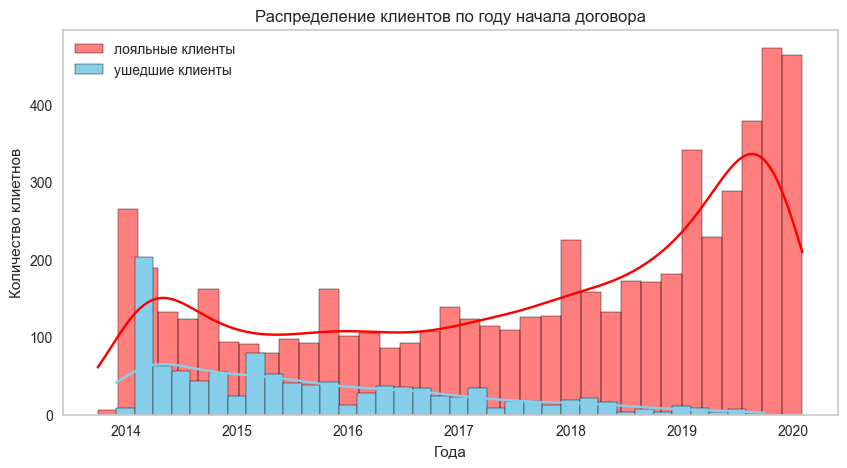

In [39]:
title_1 = "Распределение клиентов по году начала договора"
x_1 = "Года" 
y_1 = "Количество клиетнов"
hist(loyal_customer['begin_date'],last_customer['begin_date'],title_1, x_1, y_1)

Мы видим, что больше всего лояльных клиентов заключили договор в в 2020 году, то есть новые клиенты. А ушедшие клиенты по большей части старые, которые заключали договор в 2014 и 2015 годах.
Также мы можем отметить тенденцию, что с каждым годом количество лояльных клиентов увеличивается, а количество ушедших уменьшается.
Многие клиенты, которые подключились в 2014 - 2015 отказались от услуг компании.

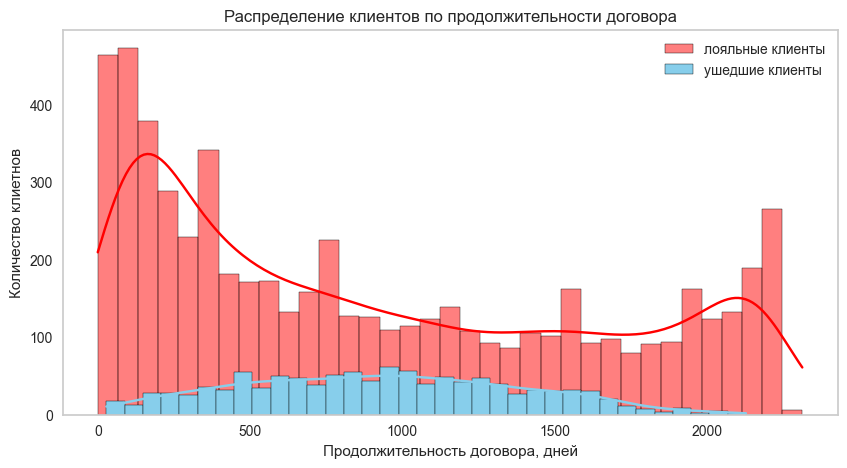

In [40]:
title_2 = "Распределение клиентов по продолжительности договора"
x_2 = "Продолжительность договора, дней" 
y_2 = "Количество клиетнов"
hist(loyal_customer['tenure'],last_customer['tenure'],title_2, x_2, y_2)

Мы также видим, что среди лояльных клиентов больше всего, тех, кто пользуется услугами полгода , а среди ушедших клиентов, кто от 1 до 4 лет (от 365 до 1500 дней). Также уходят клиенты с большой продолжительностью договора.

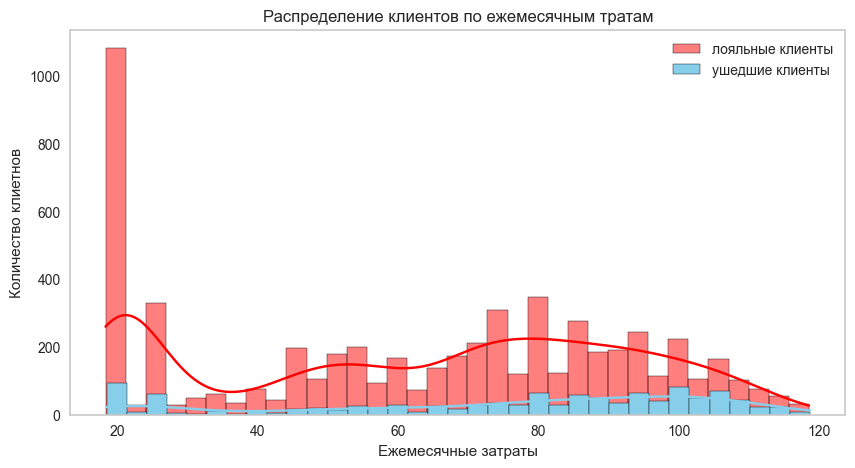

In [41]:
title_3 = "Распределение клиентов по ежемесячным тратам"
x_3 = "Ежемесячные затраты" 
y_3 = "Количество клиетнов"
hist(loyal_customer['monthly_charges'],last_customer['monthly_charges'],title_3, x_3, y_3)

Ежемесячные траты лояльных клиентов в основном 20 у.е., а ушедшие чаще всего тратили от 20-25 у.е. и 100 у.е.
Большинство клиентов пользуются минимальным набором услуг.

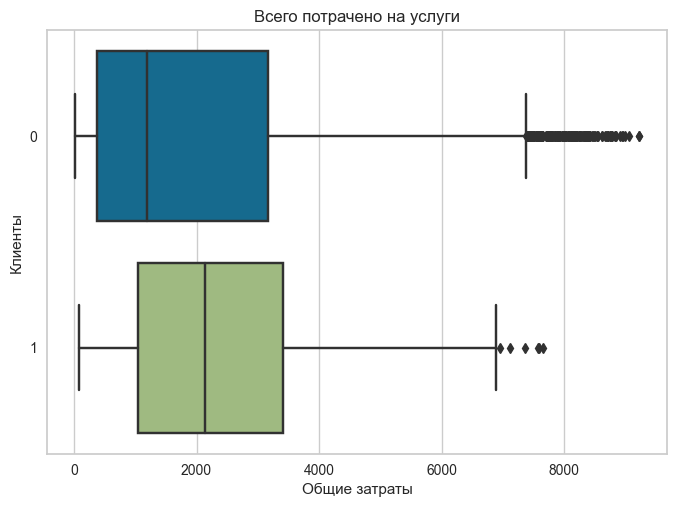

In [42]:
ax = sns.boxplot\
(x = data['total_charges'], y = data['exit'].astype(str))

ax.set_title('Всего потрачено на услуги')
ax.set(xlabel='Общие затраты', ylabel='Клиенты');

Медиана у лояльных клиентов около 1000 у.е., у ушедших клиентов чуть больше 2000 у.е.

Нижний квартиль лояльные клиенты - 300- 400 у.е., ушедшие - около 1000 у.е.

Верхний квартиль лояльные клиенты около 3000 у.е., ушедшие - 3500 у.е.

Максимальные значения у лояльных клиентов от 7000 до 9000 у.е., у ушедших от 6500 до 8000 у.е.


Сделаем срез данных по максимальным значениям:

In [44]:
#лояльные клиенты
loyal_customer.query('total_charges >=7000')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure,exit,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
17,9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),106.70,8257.51,2163,0,...,No,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes
57,5067-XJQFU,2014-08-01,2020-02-01,One year,Yes,Electronic check,108.45,7730.32,2010,0,...,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
59,5954-BDFSG,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),107.50,7740.00,2191,0,...,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
72,1891-QRQSA,2014-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),111.60,7142.40,1949,0,...,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
106,6728-DKUCO,2014-02-01,2020-02-01,One year,Yes,Electronic check,104.15,7498.80,2191,0,...,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,0218-QNVAS,2014-03-01,2020-02-01,One year,No,Bank transfer (automatic),100.55,7638.78,2163,0,...,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes
7022,7203-OYKCT,2014-02-01,2020-02-01,One year,Yes,Electronic check,104.95,8085.35,2191,0,...,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7023,1035-IPQPU,2014-11-01,2020-02-01,Month-to-month,Yes,Electronic check,103.50,7042.14,1918,0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,2191,0,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


In [45]:
#ушедшие клиенты
last_customer.query('total_charges >=6500')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure,exit,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
193,9680-NIAUV,2014-02-01,2018-11-01,Two year,No,Credit card (automatic),109.70,6690.60,1734,1,...,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Yes
2508,9405-GPBBG,2014-10-01,2020-01-01,Two year,Yes,Credit card (automatic),110.50,6961.50,1918,1,...,No,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
2885,7923-IYJWY,2014-07-01,2019-03-01,Two year,Yes,Credit card (automatic),116.10,6891.70,1704,1,...,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3107,5038-ETMLM,2014-02-01,2018-09-01,Two year,Yes,Bank transfer (automatic),113.65,6500.78,1673,1,...,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3517,0748-RDGGM,2014-02-01,2019-10-01,One year,Yes,Bank transfer (automatic),109.50,7594.92,2068,1,...,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No
3694,1150-WFARN,2014-05-01,2019-05-01,Two year,Yes,Credit card (automatic),108.75,7112.25,1826,1,...,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
4649,5172-RKOCB,2014-02-01,2018-11-01,Two year,Yes,Credit card (automatic),108.95,6582.76,1734,1,...,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes
4737,9298-WGMRW,2014-02-01,2019-05-01,Two year,Yes,Bank transfer (automatic),115.50,7567.56,1915,1,...,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6035,9835-ZIITK,2014-06-01,2020-01-01,One year,Yes,Electronic check,110.85,7649.76,2040,1,...,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
6101,4627-MIHJH,2014-05-01,2019-08-01,Two year,No,Credit card (automatic),110.25,7362.50,1918,1,...,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes


Мы видим, что обоих случаях максимальные значения у "старых" клиентов, обслуживающихся в компании с 2014 года, поэтому значения не являются выбросами.

In [46]:
#напишем функцию для сравнения категориальных признаков

def pie(df_1,df_2, title_1, title_2):
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    df_1.value_counts().plot(kind='pie', autopct='%.0f%%')
    plt.title(title_1)
    plt.ylabel("")
    plt.legend()
    plt.subplot(122)
    df_2.value_counts().plot(kind='pie',  autopct='%.0f%%')
    plt.title(title_2)
    plt.ylabel("")
    plt.legend();

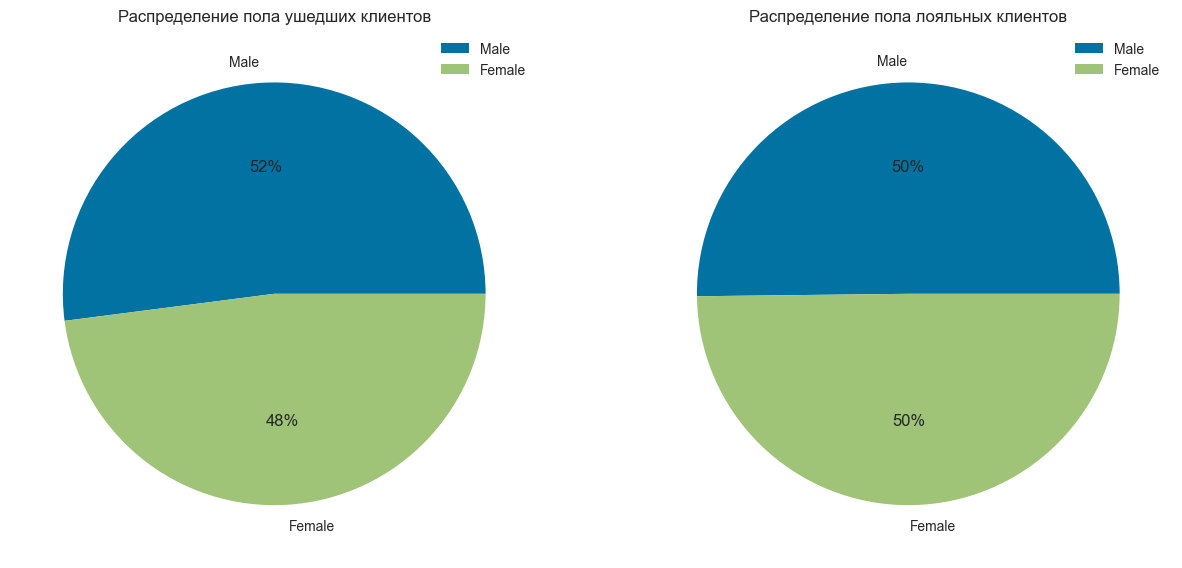

In [47]:
g_1 = ("Распределение пола ушедшиx клиентов")
g_2 = ("Распределение пола лояльных клиентов")
pie(last_customer['gender'], loyal_customer['gender'],g_1, g_2)

Гендерное распределение у групп почти одинаковое.

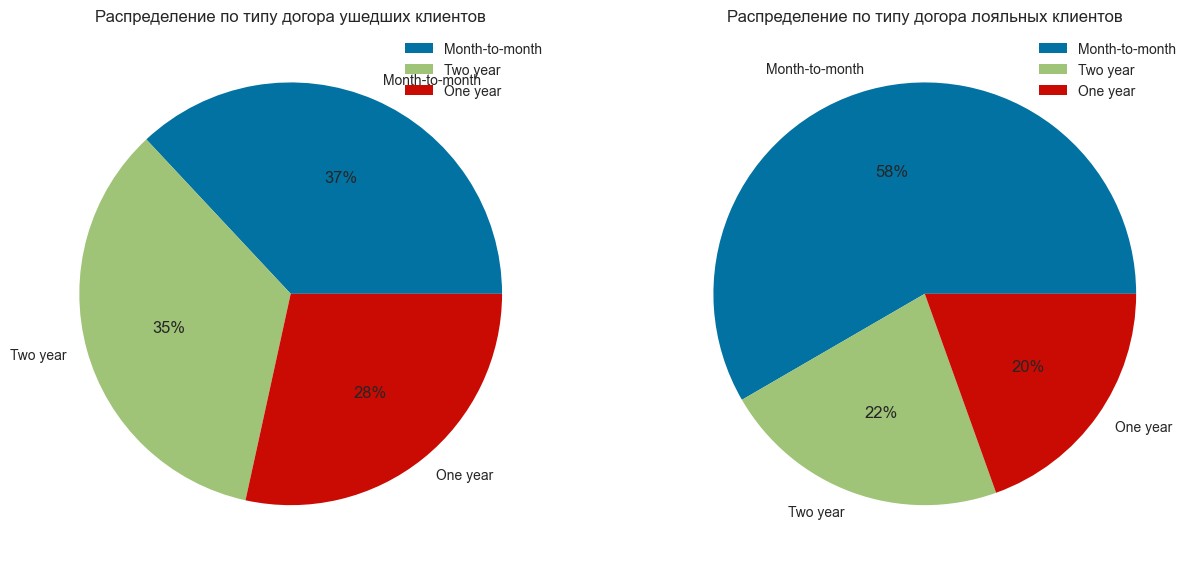

In [48]:
t_1 = ("Распределение по типу догора ушедшиx клиентов")
t_2 = ("Распределение по типу догора лояльных клиентов")
pie(last_customer['type'], loyal_customer['type'],t_1, t_2)

Здесь мы наблюдаем, что ушедшие клиенты чаще подписывали договора на 1 и 2 года, у лояльных же преимущественно ежемесячные договора.

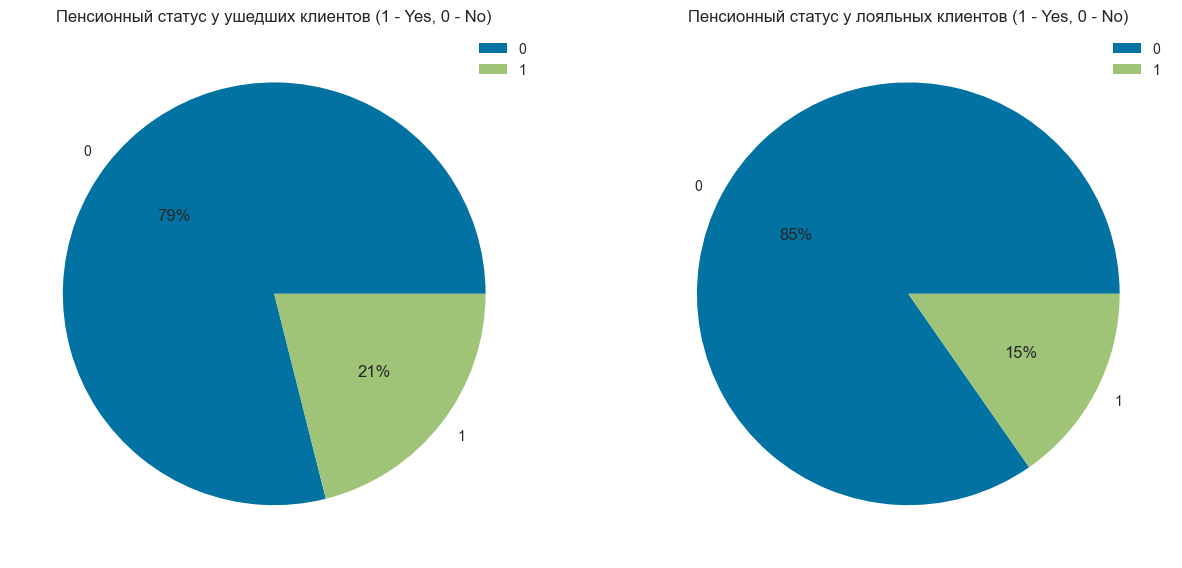

In [49]:
sc_1 = "Пенсионный статус у ушедшиx клиентов (1 - Yes, 0 - No)"
sc_2 = "Пенсионный статус у лояльных клиентов (1 - Yes, 0 - No)"
pie(last_customer['senior_citizen'], loyal_customer['senior_citizen'], sc_1, sc_2)

Ушедших пенсионеров чуть больше.

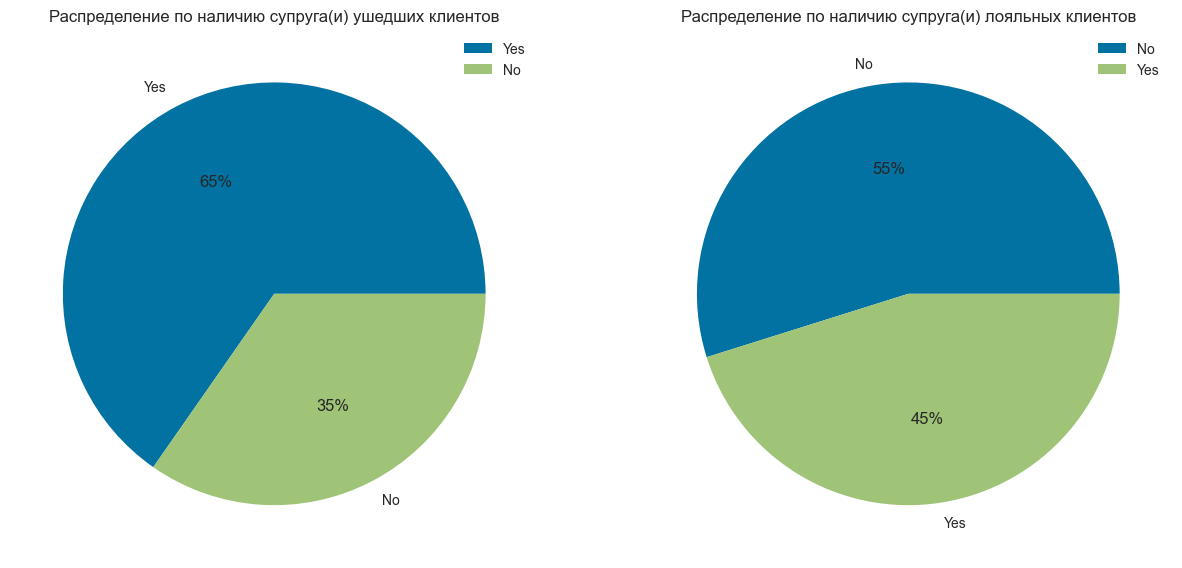

In [50]:
p_1 = "Распределение по наличию супруга(и) ушедшиx клиентов"
p_2 = "Распределение по наличию супруга(и) лояльных клиентов"
pie(last_customer['partner'], loyal_customer['partner'], p_1, p_2)

У ушедших клиентов на 10 процентов больше зарегистрированных в браке.

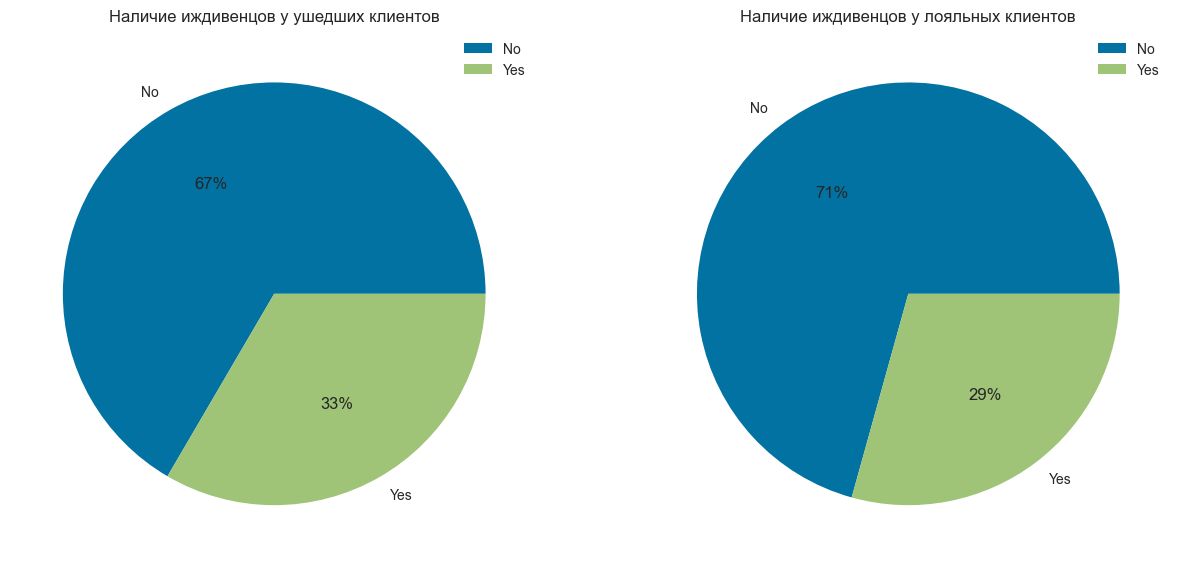

In [51]:
d_1 = "Наличие иждивенцов у ушедшиx клиентов"
d_2 = "Наличие иждивенцов у лояльных клиентов"
pie(last_customer['dependents'], loyal_customer['dependents'], d_1, d_2)

Сильных отличий нет, в обоих случаях клиентов без иждивенцов больше.

Посмотрим на дополнительные услуги:

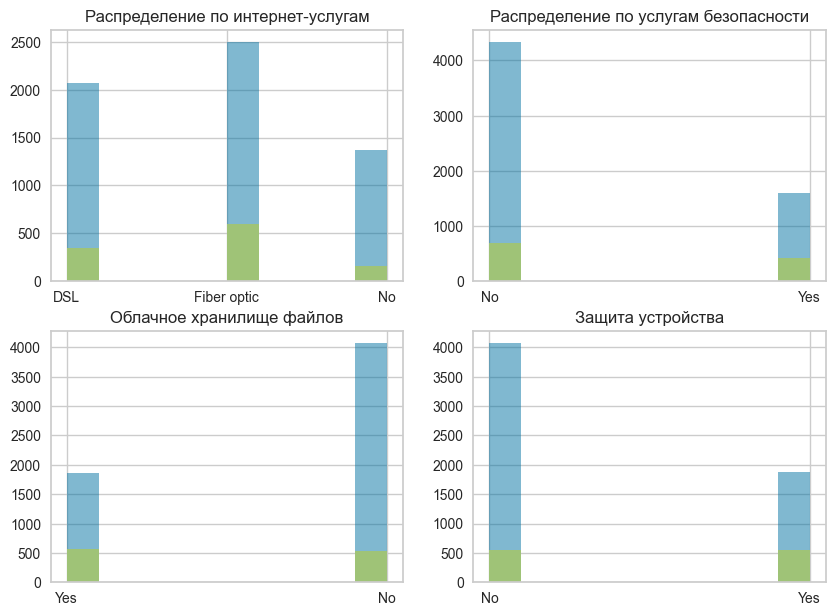

In [52]:
plt.figure(figsize=(10,15))
plt.subplot(421)
loyal_customer['internet_service'].hist( alpha=0.5)
last_customer['internet_service'].hist(alpha=1);
plt.title("Распределение по интернет-услугам")
plt.ylabel("")

plt.subplot(422)
loyal_customer['online_security'].hist( alpha=0.5)
last_customer['online_security'].hist(alpha=1);
plt.title("Распределение по услугам безопасности")
plt.ylabel("");

plt.subplot(423)
loyal_customer['online_backup'].hist( alpha=0.5)
last_customer['online_backup'].hist(alpha=1);
plt.title("Облачное хранилище файлов")
plt.ylabel("")

plt.subplot(424)
loyal_customer['device_protection'].hist( alpha=0.5)
last_customer['device_protection'].hist(alpha=1);
plt.title("Защита устройства")
plt.ylabel("");

На гистограммах мы видим, что распределение по интернет-услугам и услугам безопасности у ушедших и лояльных клиентов одинаковое, чаще выбирают оптоволоконный кабель (Fiber optic) и чаще не пользуются услугами безопасности.

Услуга облачное хранилище и защита устройства  у ушедших клиентов распределена в равной степени, а лояльные клиенты чаще отказывается от этих услуг.

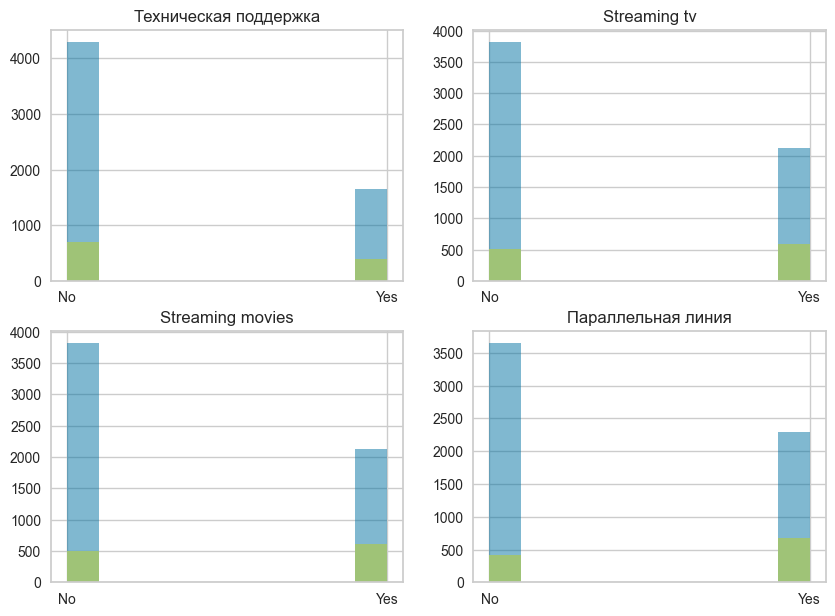

In [53]:
plt.figure(figsize=(10,15))
plt.subplot(421)
loyal_customer['tech_support'].hist( alpha=0.5)
last_customer['tech_support'].hist(alpha=1)
plt.title("Техническая поддержка")
plt.ylabel("")

plt.subplot(422)
loyal_customer['streaming_tv'].hist( alpha=0.5)
last_customer['streaming_tv'].hist(alpha=1)
plt.title("Streaming tv")
plt.ylabel("");

plt.subplot(423)
loyal_customer['streaming_movies'].hist( alpha=0.5)
last_customer['streaming_movies'].hist(alpha=1)
plt.title("Streaming movies")
plt.ylabel("")

plt.subplot(424)
loyal_customer['multiple_lines'].hist( alpha=0.5)
last_customer['multiple_lines'].hist(alpha=1)
plt.title("Параллельная линия")
plt.ylabel("");

Техническая поддержка: и лояльные и ушедшие чаще всего не пользуются.

Streaming tv: ушедших клиентов, которые выбирали эту доп услугу чуть больше, лояльные клиенты чаще отказываются

Streaming movies: распределение абсолютно аналогично Streaming tv

Услугами параллельной линии ушедшие клиенты пользовались активнее, лояльные чаще отказывались.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'tenure', 'exit', 'senior_citizen']


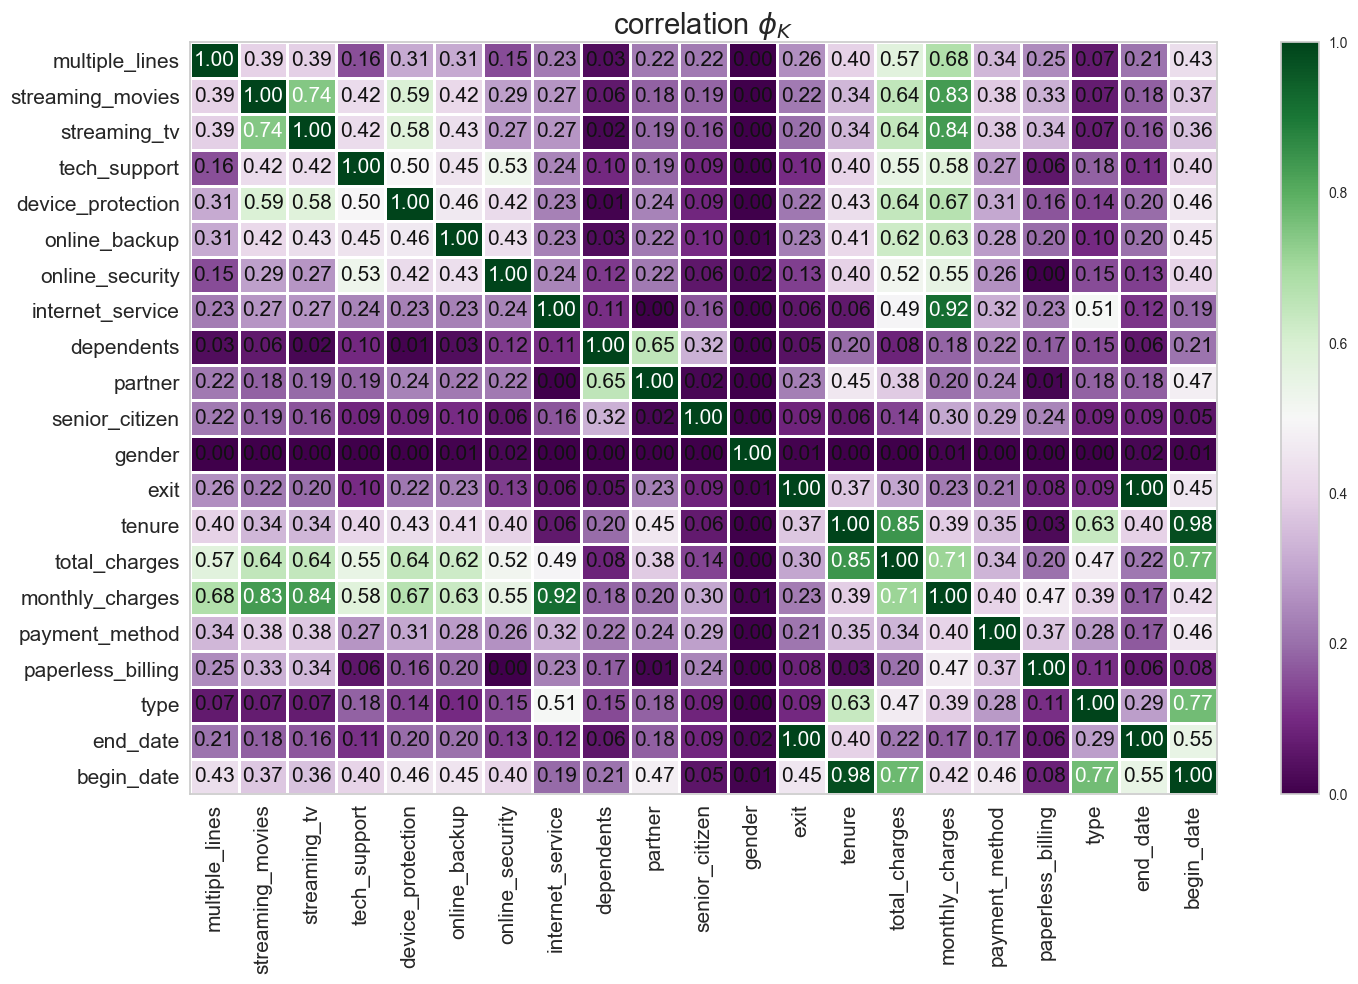

In [54]:
#проведем корреляционнный анализ
phik_overview  = data.drop(['customer_id'], axis = 1).phik_matrix()

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='PRGn', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15, 10))
plt.tight_layout()

Мы видим, что доп услуги internet_service, streaming_movies, streaming_tv влияют на ежемесячные траты.

Дата начала договора сильно коррелирует с продолжительностью договора (коэф. 0.98)

Дата окончания договора имеет коэффицент корреляции 1 с целевым признаком, это означает утечку, поэтому все столбцы с датами мы удалим.

Также удалим общие затраты total_charges, так как сильная корреляция (0.85) с продолжительностью договора tenure.

In [55]:
data = data.drop(['customer_id', 'begin_date','end_date','total_charges'], axis=1)
data.head()

,type,paperless_billing,payment_method,monthly_charges,tenure,exit,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,56.95,1036,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,123,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1371,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,70.70,153,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


***Вывод:***
 -  больше всего лояльных клиентов заключили договор в в 2020 году, то есть это новые клиенты, а ушедшие клиенты по чаще заключали договор в 2014 и 2015 годах, то есть ушло много "старых" клиентов
 - мы можем отметить тенденцию, что с каждым годом количество лояльных клиентов увеличивается, а количество ушедших уменьшается
 - в 2014 - 2015 году отток клиентов был самый высокий
 - ежемесячные траты лояльных клиентов в основном 20 у.е., а ушедшие чаще всего тратили от 20-25 у.е. и 100 у.е.
 - медиана общих затрат у лояльных клиентов около 1000 у.е., у ушедших клиентов чуть больше 2000 у.е., так как ушли в основном клиенты с продолжительностью договора от 1 до 4 лет
 - гендерное распрделение у двух групп почти не отличается, как и наличие иждивенцов
 - количество ушедших пенсионеров больше на 6%, чем у лояльных
 - ушедшие клиенты чаще подписывали договора на 1 и 2 года, у лояльных же преимущественно ежемесячные договора
 - среди ушедших клиентов на 10 процентов больше зарегистрированных в браке
 - распределение по интернет-услугам и услугам безопасности у ушедших и лояльных клиентов одинаковое
 - услуга облачное хранилище и защита устройства у ушедших клиентов распределена в равной степени, а лояльные клиенты чаще отказывается от этих услуг
 - технической поддержкой и лояльные, и ушедшие чаще всего не пользуются
 - Streaming tv: ушедших клиентов, которые выбирали эту доп услугу чуть больше, лояльные клиенты чаще отказываются
 - услугами параллельной линии ушедшие клиенты пользовались активнее, лояльные чаще отказывались
 
 Также мы провели корреляционные анализ и исключили столбцы, которые будут мешать обучению модели.


## Обучение моделей

### Разделение на выборки

In [56]:
RANDOM_STATE = 80523

In [57]:
#выделим признаки и целевой признак
features = data.drop(['exit'], axis=1)
target = data['exit']

In [58]:
#выделим 75% для обучающей выборки и 25% для тестовой
features_train, features_test, target_train,target_test = \
train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [59]:
#выведем размеры, полученных таблиц
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5282, 17)
(5282,)
(1761, 17)
(1761,)


### Кодирование признаков

In [60]:
#выделяем столбцы
category = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'senior_citizen']
numeric = ['monthly_charges','tenure']

In [61]:
#закодируем признаки
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe.fit(features_train[category])
new_col = ohe.get_feature_names_out(category)

def one_hot(features):
    features_ohe = pd.DataFrame \
    (ohe.transform(features[category]).toarray(), columns = new_col, index = features.index)
    features_ohe  = features_ohe.join(features[numeric])
    return features_ohe

In [62]:
# #кодируем обучающую выборку
features_train_ohe = one_hot(features_train)
features_train_ohe.T

,2122,5299,525,2099,3992,3566,4706,552,611,4578,...,3963,2011,6835,2547,5541,5893,3611,2731,4159,4465
type_One year,1.00,0.0,1.00,0.00,0.0,1.0,0.00,0.00,0.0,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.00,0.00,1.00
type_Two year,0.00,0.0,0.00,0.00,1.0,0.0,0.00,1.00,0.0,0.00,...,1.0,0.0,0.0,1.0,1.0,1.0,1.00,0.00,0.00,0.00
paperless_billing_Yes,1.00,1.0,0.00,1.00,0.0,1.0,1.00,0.00,0.0,1.00,...,0.0,0.0,1.0,0.0,1.0,1.0,1.00,0.00,1.00,1.00
payment_method_Credit card (automatic),0.00,1.0,0.00,1.00,0.0,0.0,0.00,0.00,0.0,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,1.00,1.00,0.00,0.00
payment_method_Electronic check,0.00,0.0,1.00,0.00,0.0,1.0,0.00,0.00,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.00,0.00,1.00,1.00
payment_method_Mailed check,1.00,0.0,0.00,0.00,1.0,0.0,1.00,0.00,1.0,1.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.00,0.00
gender_Male,0.00,0.0,1.00,0.00,0.0,0.0,0.00,1.00,0.0,0.00,...,0.0,1.0,1.0,0.0,0.0,1.0,1.00,0.00,0.00,1.00
partner_Yes,0.00,1.0,0.00,1.00,0.0,0.0,0.00,1.00,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,1.0,0.00,0.00,0.00,0.00
dependents_Yes,0.00,0.0,0.00,0.00,0.0,1.0,0.00,1.00,1.0,0.00,...,0.0,1.0,0.0,0.0,0.0,1.0,0.00,0.00,0.00,0.00
internet_service_Fiber optic,0.00,1.0,1.00,1.00,0.0,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,1.0,0.0,1.0,0.0,1.00,1.00,1.00,0.00


In [64]:
#кодируем тестовую выборку
features_test_ohe = one_hot(features_test)
features_test_ohe.T

,908,2130,6814,6080,905,4045,4861,44,3513,5821,...,197,1051,3177,4066,1550,3778,6438,4930,4681,6872
type_One year,0.00,1.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,1.0,...,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.00,0.00,1.00
type_Two year,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.0,1.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
paperless_billing_Yes,0.00,1.0,0.0,0.0,1.0,1.0,1.00,1.0,0.00,1.0,...,1.00,1.0,0.0,1.00,1.0,0.0,1.0,1.00,1.00,1.00
payment_method_Credit card (automatic),0.00,0.0,1.0,0.0,0.0,1.0,0.00,0.0,0.00,0.0,...,0.00,1.0,0.0,0.00,0.0,0.0,0.0,1.00,0.00,1.00
payment_method_Electronic check,0.00,1.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,1.0,...,1.00,0.0,0.0,0.00,1.0,0.0,1.0,0.00,1.00,0.00
payment_method_Mailed check,1.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.0,1.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
gender_Male,0.00,1.0,0.0,1.0,1.0,0.0,0.00,0.0,1.00,0.0,...,1.00,0.0,1.0,1.00,1.0,1.0,1.0,0.00,1.00,0.00
partner_Yes,0.00,0.0,1.0,0.0,0.0,0.0,1.00,1.0,1.00,1.0,...,0.00,1.0,1.0,0.00,1.0,0.0,0.0,0.00,0.00,1.00
dependents_Yes,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.0,...,0.00,1.0,1.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
internet_service_Fiber optic,0.00,1.0,1.0,0.0,1.0,1.0,0.00,0.0,0.00,0.0,...,1.00,0.0,0.0,0.00,1.0,0.0,1.0,0.00,1.00,1.00


In [65]:
#проверяем размеры
features_train_ohe.shape, features_test_ohe.shape

((5282, 21), (1761, 21))

In [66]:
#создадим функцию для вывода результата в таблице
model_name = ['LogisticRegression', 'LGBMClassifier','CatBoostClassifier']
def model_score(model, model_name, features,target):
    auc_roc = model.best_score_
    acc = cross_val_score(model, features,target, scoring = 'accuracy').mean()
    result = {'model_name':[model_name],\
    'AUC-ROC':[auc_roc],\
    'Accuracy':[acc]}
    result = pd.DataFrame(result)
    return result

### Логистическая регрессия

In [67]:
#масштабируем данные для логистической регрессии
scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_lr= scaler.transform(features_train_ohe)
features_test_lr = scaler.transform(features_test_ohe)

In [68]:
#подберем параметры с помощью GridSearch
model_lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

grid_params_lr = { 'C': range(3,10)}
gs_lr = GridSearchCV(model_lr , grid_params_lr, scoring='roc_auc',  cv=7)
gs_lr.fit(features_train_lr, target_train)

print(gs_lr.best_estimator_)
print(gs_lr.best_score_)
print(gs_lr.best_params_)

LogisticRegression(C=8, class_weight='balanced', random_state=80523)
0.7620658190285466
{'C': 8}


In [69]:
#выведем метрику AUC-ROC и дополнительную метрику Accuracy в таблицу

res_lr = model_score(gs_lr, model_name[0], features_train_lr,target_train)
res_lr

,model_name,AUC-ROC,Accuracy
0,LogisticRegression,0.762066,0.702013


### LGBMClassifier

In [70]:
%%time


#подберем параметры с помощью GridSearch

estimator = LGBMClassifier(objective="binary", class_weight='balanced', random_state=RANDOM_STATE)
grid_params = {'learning_rate' : [0.1, 0.03,0.04],
               'n_estimators': [50,100,200,300]
                }

gbm = GridSearchCV(estimator, grid_params, scoring = 'roc_auc', cv=7)
gbm.fit(features_train_ohe, target_train)
print(gbm.best_estimator_)
print(gbm.best_score_)
print(gbm.best_params_)

LGBMClassifier(class_weight='balanced', n_estimators=300, objective='binary',
               random_state=80523)
0.8953462308604815
{'learning_rate': 0.1, 'n_estimators': 300}
CPU times: user 1min 8s, sys: 12.8 s, total: 1min 21s
Wall time: 11.2 s


In [71]:
#выведем метрику AUC-ROC и дополнительную метрику Accuracy в таблицу
res_gbm = model_score(gbm, model_name[1], features_train_ohe,target_train)
res_gbm

,model_name,AUC-ROC,Accuracy
0,LGBMClassifier,0.895346,0.884703


### CatBoostClassifier

In [72]:
%%time

cbr = CatBoostClassifier(class_weights=(1,5),random_state=RANDOM_STATE, verbose=False)


grid_param_cbr = {'depth'         : [4,5,6],
                 'learning_rate' : [0.01,0.03,0.04],
                  'iterations'    : [100,200,300]}
gs_cbr = GridSearchCV (cbr, grid_param_cbr, scoring = 'roc_auc')
gs_cbr.fit(features_train_ohe, target_train)


print(gs_cbr.best_estimator_)
print(gs_cbr.best_score_)
print(gs_cbr.best_params_)

0.8606507075031425
{'depth': 5, 'iterations': 300, 'learning_rate': 0.04}
CPU times: user 53.9 s, sys: 36.4 s, total: 1min 30s
Wall time: 35.3 s


In [73]:
#выведем метрику AUC-ROC и дополнительную метрику Accuracy в таблицу
res_cbr = model_score(gs_cbr, model_name[2], features_train_ohe,target_train)
res_cbr

,model_name,AUC-ROC,Accuracy
0,CatBoostClassifier,0.860651,0.79099


### Анализ результатов

In [74]:
#создадим функцию для вывода предсказаний для ROC-кривой 
def roc_acc(model,features,target):
    probabilities = cross_val_predict(model,features,target, method="predict_proba")
    probabilities_one = probabilities[:, 1]
    return probabilities_one

y_pred_prob_log = roc_acc(gs_lr, features_train_lr, target_train)
y_pred_prob_gbm = roc_acc(gbm, features_train_lr, target_train)
y_pred_prob_cat = roc_acc(gs_cbr, features_train_lr, target_train)

,model_name,AUC-ROC,Accuracy
0,LGBMClassifier,0.895346,0.884703
1,CatBoostClassifier,0.860651,0.790990
2,LogisticRegression,0.762066,0.702013


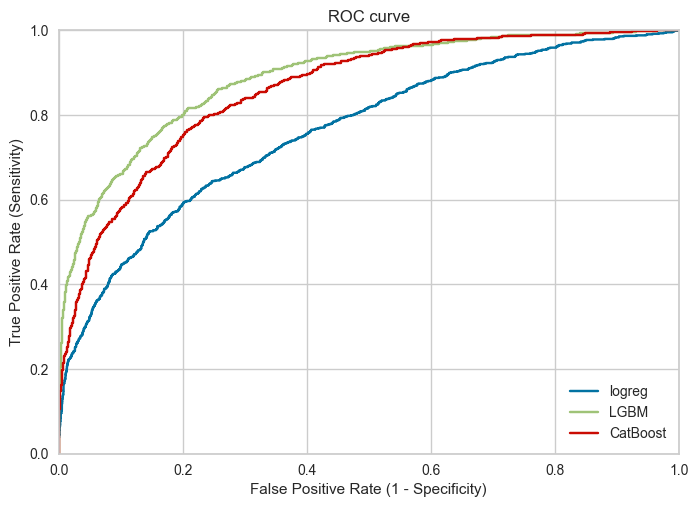

In [75]:
#выведем ROC-кривые наших моделей
fpr_logreg, tpr_logreg, thresholds_logreg = metrics.roc_curve(target_train, y_pred_prob_log)
fpr_gbm, tpr_gbm, thresholds_gbm = metrics.roc_curve(target_train, y_pred_prob_gbm)
fpr_cat, tpr_cat, thresholds_cat = metrics.roc_curve(target_train, y_pred_prob_cat)

plt.plot(fpr_logreg, tpr_logreg, label="logreg")
plt.plot(fpr_gbm, tpr_gbm, label="LGBM")
plt.plot(fpr_cat, tpr_cat, label="CatBoost")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

#объединим метрики моделей в одну таблицу
result = pd.concat([res_lr, res_gbm,res_cbr], axis=0).sort_values(by = 'AUC-ROC', ascending=False)
result.reset_index(drop=True)

Самый высокий показатель AUC-ROC у модели LGBMClassifier. Будем проводить тестирование на ней.

## Тестирование лучшей модели

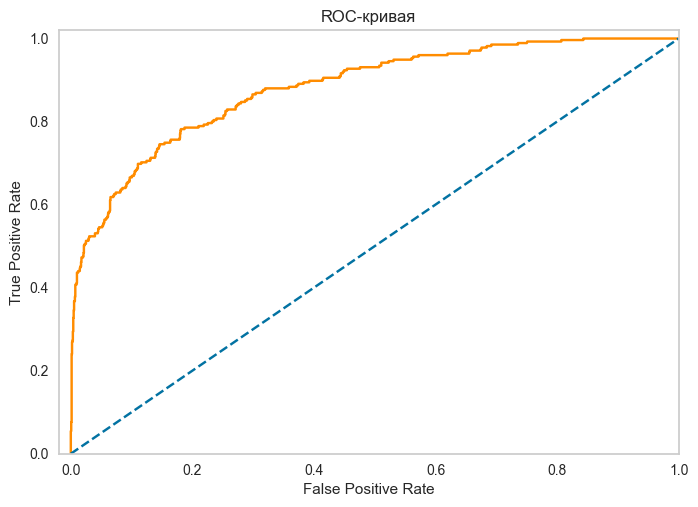

AUC-ROC: 0.8798837636118929
Accuracy: 0.8807495741056218


In [76]:
#проверяем AUC-ROC на тестовой выборке
probabilities = gbm.best_estimator_.predict_proba(features_test_ohe)
probabilities_one = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)
plt.figure()
plt.plot(fpr, tpr, color="darkorange") 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая") 
plt.grid()
plt.show()
auc_roc = roc_auc_score(target_test, probabilities_one)
print('AUC-ROC:', auc_roc)
target_pred = gbm.best_estimator_.predict(features_test_ohe)
acc = accuracy_score(target_test, target_pred)
print('Accuracy:', acc)                    
                                

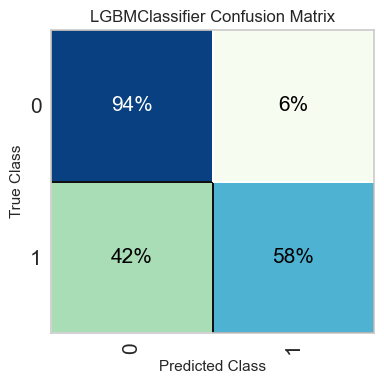

In [77]:
#посмотрим на матрицу ошибок сбалансированной модели LGBM
cm = ConfusionMatrix(gbm.best_estimator_, percent=True, classes=[0,1], size=(400,400),
fontsize=15, cmap='GnBu')
cm.fit(features_train_ohe, target_train)
cm.score(features_test_ohe, target_test)
cm.show();

С помощью LGBMClassifier и сбалансировании классов мы добились предсказания положительного класса (1-ушедшие клиенты) на 58%. Модель лучше работает на отрицательном классе (0 - лояльные клиенты) - 94%.

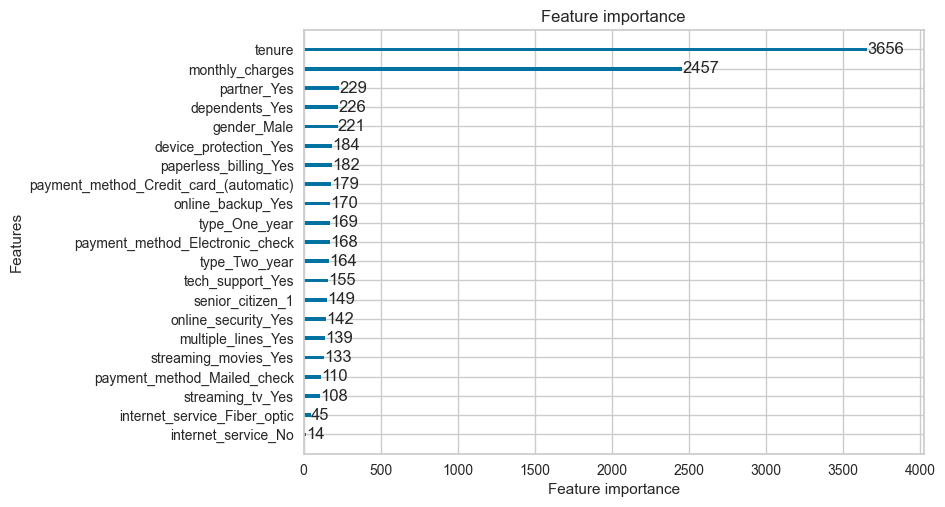

In [78]:
#посмотрим на важные признаки для модели
plot_importance(gbm.best_estimator_)
plt.show()

Самые важные признаки это ежемесячные затраты и продолжительность договора.

## Общий вывод

В нашем проекте провели следющие этапы:
  - предобработали данные: привели названия столбцов к змеиному регистр, поменяли типы данных в столбцах        begin_date, end_date,total_charges, заполнили пропуски в столбце total_charges у новых клиентов ежемесячными тратами, заполнили возникшие в доп услугах пропуски при объединении значением 'No'
- сгенерировали новый признак tenure (сколько дней клиент пользуется услугами)
- создали целевой признак exit, где 1 - ушедшие клиенты, а 0 - лояльные клиенты
- выявили дисбаланс классов
- провели исследовательские анализ и выявили:
   -  больше всего лояльных клиентов заключили договор в в 2020 году, то есть это новые клиенты, а ушедшие клиенты по чаще заключали договор в 2014 и 2015 годах, то есть ушло много "старых" клиентов
   - мы можем отметить тенденцию, что с каждым годом количество лояльных клиентов увеличивается, а количество ушедших уменьшается
   - в 2014 - 2015 году отток клиентов был самый высокий
   - ежемесячные траты лояльных клиентов в основном 20 у.е., а ушедшие чаще всего тратили от 20-25 у.е. и 100 у.е.
   - медиана общих затрат у лояльных клиентов около 1000 у.е., у ушедших клиентов чуть больше 2000 у.е., так как ушли в основном клиенты с продолжительностью договора от 1 до 4 лет
   - гендерное распрделение у двух групп почти не отличается, как и наличие иждивенцов
   - количество ушедших пенсионеров больше на 6%, чем у лояльных
   - ушедшие клиенты чаще подписывали договора на 1 и 2 года, у лояльных же преимущественно ежемесячные договора
   - среди ушедших клиентов на 10 процентов больше зарегистрированных в браке
   - распределение по интернет-услугам и услугам безопасности у ушедших и лояльных клиентов одинаковое
   - услуга облачное хранилище и защита устройства у ушедших клиентов распределена в равной степени, а лояльные клиенты чаще отказывается от этих услуг
   - технической поддержкой и лояльные, и ушедшие чаще всего не пользуются
   - Streaming tv: ушедших клиентов, которые выбирали эту доп услугу чуть больше, лояльные клиенты чаще отказываются
   - услугами параллельной линии ушедшие клиенты пользовались активнее, лояльные чаще отказывались
   - провели корреляционные анализ и исключили столбцы, которые будут мешать обучению модели
- разбили наш датасет на тренирововчную и тестовую выборки (75%/25%)
- закодировали данные с помощью OneHotEncoder()
- выбрали метрику AUC-ROC — метрика, которая учитывает возможность балансировать между false posititve (клиент не собирался уходить)и false negative(клиент ушел),в качестве дополнительной метрики рассчитали accuracy
- для логистической регрессии стнадартизировали данные с помощью StandardScaler()
- подбирали гиперпараметры для моделей с помощью GridSearch
- выявили лучшую модель LGBMClassifier с показателем  AUC-ROC при подборе лучших параметров: 0.895346
- провели тестирование модели с результатом AUC-ROC: 0.87988376, что соответствует заявленным требованиям
- предсказания положительного класса (1-ушедшие клиенты) на 58%, на отрицательном классе (0 - лояльные клиенты) - 94%
- самые важные признаки для модели - ежемесячные затраты и продолжительность договора

<h1><center>Отчет по проекту «Прогнозирование оттока клиентов «Ниединогоразрыва.ком»</center></h1>


***Задача заказчика:*** научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

***Данные:*** команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

***Признаки:***

- BeginDate – дата начала пользования услугами

- Type – тип оплаты: ежемесячный, годовой и тд

- PaperlessBilling – безналичный расчет

- PaymentMethod – способ оплаты

- MonthlyCharges – ежемесячные траты на услуги

- TotalCharges – всего потрачено денег на услуги

- Dependents – наличие иждивенцев

- Senior Citizen – наличие пенсионного статуса по возрасту

- Partner – наличие супруга(и)

- MultipleLines – наличие возможности ведения параллельных линий во время звонка

- EndDate - дата окончания договора (целевой признак)

***Критерии оценки:*** AUC-ROC >= 0.85

Было проведено  ***4 ключевых этапа***:
- загрузка и предобработка данных
- исследовательский анализ данных
- подготовка признаков и обучение моделей
- тестирование лучшей модели

**1. Предобработка данных**

В данных по договору (contract):
- привели названия столбцов к змеиному регистру для удобства
- выявили несоотвествие  типа данных в в столбцах begin_date, end_date,total_charges и поменяли их
- обнаружили пропуски у новых клиентов в столбце total_charges (всего затрат) и заполнили их ежемесячными тратами
- создали ***новый признак tenure*** (продолжительность договора, в днях)
- создали ***целевой признак exit***, где 1 - ушедшие клиенты, а 0 - лояльные клиенты
- выявили дисбаланс классов

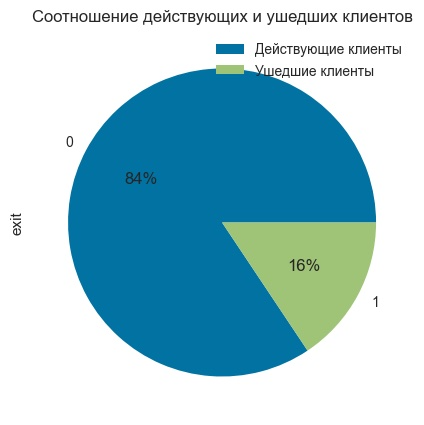


- на гистограммах увидели, что больше всего клиентов до года, ежемесячные траты чаще всего от 17 до 30 у.е., а общие траты чаще всего до 1000 у.е.

В датасетах по персональным данным, интернету и телефонии:
- привели названия столбцов к змеиному регистру
- выявили, что все признаки категориальные
- выяснили, что клиентов, пользующихся услугами телефонии, у нашего оператора больше, чем интернет-услугами

По итогу предобработки:
- объединили все таблицы в одну data
- заполнили возникшие в доп услугах пропуски при объединении значением 'No'

**2. Исследовательский анализ данных**

Для исследования мы соотносили данные по ушедшим (1) и лояльным (0) клиентам:

-  больше всего лояльных клиентов заключили договор в в 2020 году, то есть это новые клиенты, а ушедшие клиенты чаще заключали договор в 2014 и 2015 годах
 - ежемесячные траты лояльных клиентов в основном 20 у.е., а ушедшие чаще всего тратили от 20-25 у.е. и 100 у.е., большинство клиентов пользуются минимальным набором услуг
 
 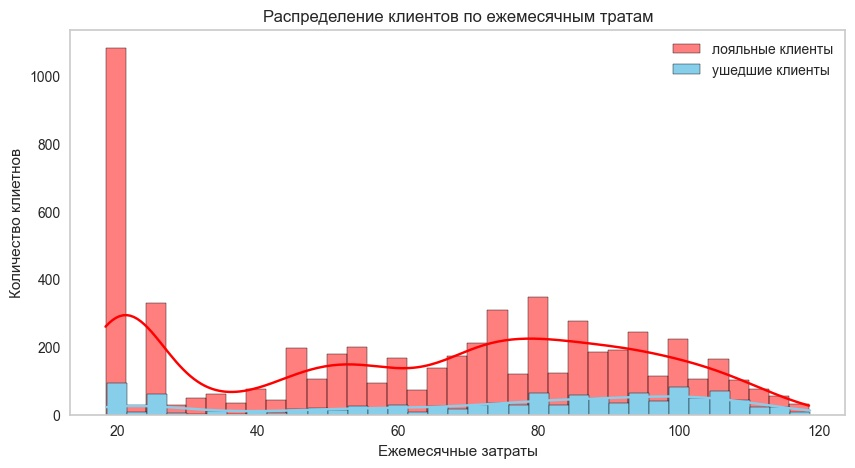
 
 - медиана общих затрат у лояльных клиентов около 1000 у.е., у ушедших клиентов чуть больше 2000 у.е., так как ушли в основном клиенты с продолжительностью договора от 1 до 4 лет
 - гендерное распрделение у двух групп почти не отличается, как и наличие иждивенцов
 - количество ушедших пенсионеров больше на 6%, чем у лояльных
 - ушедшие клиенты чаще подписывали договора на 1 и 2 года, у лояльных же преимущественно ежемесячные договора
 - среди ушедших клиентов на 10 процентов больше зарегистрированных в браке
 - распределение по интернет-услугам и услугам безопасности у ушедших и лояльных клиентов одинаковое
 - услуга облачное хранилище и защита устройства у ушедших клиентов распределена в равной степени, а лояльные клиенты чаще отказывается от этих услуг
 - технической поддержкой и лояльные, и ушедшие чаще всего не пользуются
 - Streaming tv: ушедших клиентов, которые выбирали эту доп услугу чуть больше отказавшихся, лояльные клиенты чаще не пользуются данной услугой
 - услугами параллельной линии ушедшие клиенты пользовались активнее, лояльные чаще отказывались
 
Также мы провели ***корреляционный анализ:*** 
- internet_service, streaming_movies, streaming_tv влияют на ежемесячные траты, коэффициент выше 0.8

Исключили столбцы, которые будут мешать обучению модели:
- дата начала договора, так как сильно коррелирует с продолжительностью договора (коэф. 0.98)
- дата окончания договора,так имеет коэффицент корреляции 1 с целевым признаком, это означает утечку
- общие затраты total_charges, так как сильная корреляция (0.85) с продолжительностью договора tenure

После проведенного анализа оставили следующие ***признаки для обучения*** моделей:
- категориальные: 'type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies','multiple_lines', 'senior_citizen'
- количественные:'monthly_charges','tenure'

**3. Подготовка признаков и обучение моделей**


- разбили наш датасет на тренирововчную (75%) и тестовую выборки (25%), RANDOM_STATE = 80523
- закодировали категориальные данные с помощью OneHotEncoder()
- для задачи бинарной классификации выбрали модели: ***'LogisticRegression', 'LGBMClassifier','CatBoostClassifier'***
- для логистической регрессии стандартизировали данные с помощью StandardScaler()
- для оценки выбрали метрику  ***AUC-ROC*** — метрика, которая учитывает возможность балансировать между false posititve (клиент не собирался уходить) и false negative(клиент ушел),в качестве дополнительной метрики рассчитали ***accuracy*** - доля правильных ответов алгоритма
- для логистической регрессии стандартизировали данные с помощью StandardScaler()
- подбирали гиперпараметры для моделей с помощью GridSearch

На данном этапе возникли трудности, так как метрика не поднималась выше 0.84. Была выявлена ошибка: изначально продолжительность договора была указана в годах, этот признак был слишком приблеженный для моделей и как только перевели значения столбца tenure в дни, метрика сразу улучшилась.

Итоги после обучения моделей:


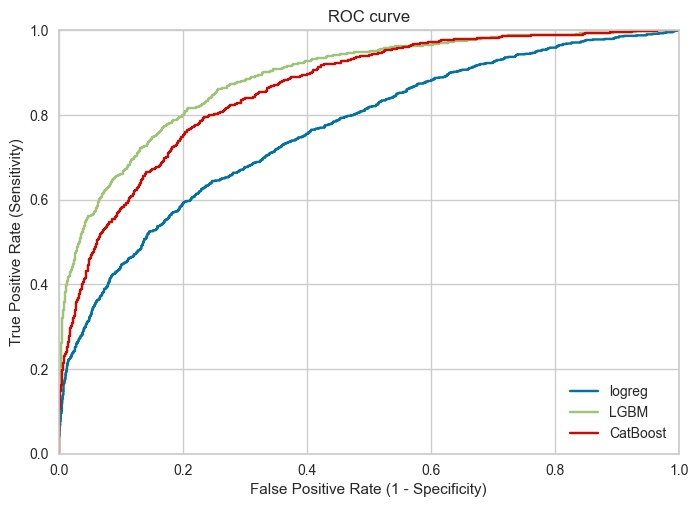


| model_name	| AUC-ROC	 | Accuracy|
| --- | --- | --- |
| LGBMClassifier| 0.895346| 0.884703 |
| CatBoostClassifier| 0.860651	| 0.790990|
| LogisticRegression | 0.762066 | 0.702013 |


- выявили лучшую модель ***LGBMClassifier*** с показателем AUC-ROC (0.895346 )с ***лучшими подобранными  с помощью GridSearch параметрами:*** 

**LGBMClassifier(class_weight='balanced', n_estimators=300, learning_rate=0.1,
objective='binary', random_state=80523)**

**4.Тестирование лучшей модели**

- провели тестирование ***лучшей модели LGBMClassifier*** с результатом ***AUC-ROC: 0.87988376***, что соответствует заявленным требованиям  AUC-ROC >= 0.85, дополнительная метрика ***Accuracy: 0.884703*** 

- выявили ***важные признаки для модели*** - ежемесячные затраты ('monthly_charges') и продолжительность договора ('tenure')

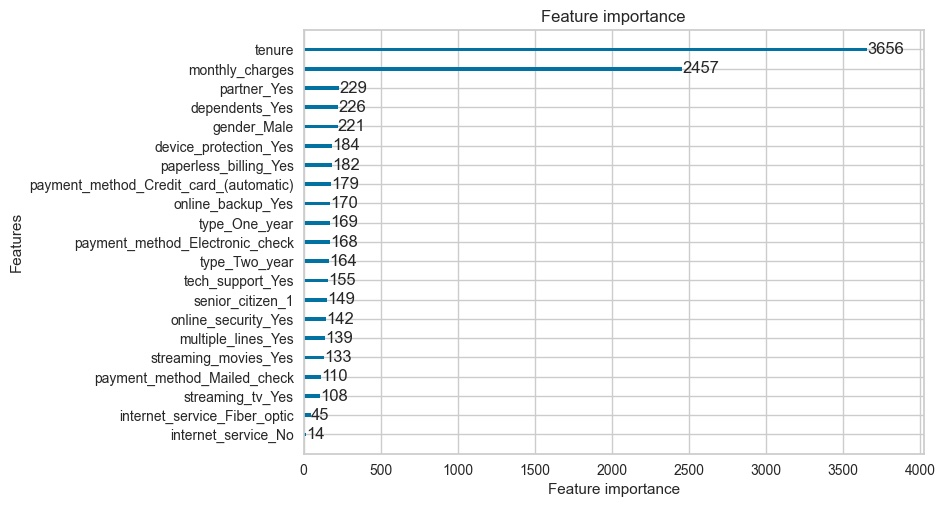

Теперь зная важные признаки мы можем улучшить нашу модель.